In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# LSTM Multivariate
Using lookback = 1

## Load and prepare the data

In [2]:
df = pd.read_csv('../cleaned_data/FREN.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,-0.077792,-0.039585,-0.041007,-0.484714,2.223844,2.575815,2.574613,1.633924,1.679844,1.552717,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,0.440118
2012-10-18,-0.003835,-0.007674,-0.010651,1.422315,0.937519,1.283190,1.404574,1.679668,1.748685,1.672304,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,0.201081
2012-10-19,0.038425,0.004293,0.002741,1.517442,1.158441,1.511092,1.626116,0.908951,0.920132,0.908441,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,0.293018
2012-10-22,0.093893,0.025567,0.019705,1.628038,1.070196,1.424646,1.546813,0.634583,0.627739,0.526947,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,0.274631
2012-10-23,0.141436,0.046841,0.028634,1.606590,0.794613,1.164224,1.310060,0.566140,0.561087,0.541269,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,0.219468


### Split the dataset into train and test

In [3]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [4]:
train_y = train_dataset[['Close']]

### Create the train dataset

In [5]:
hops = 1
train_len = len(train_dataset)

X_train = []
y_train = []

for i in range(hops, train_len):
    X_train.append(train_dataset[i-hops:i])
    y_train.append(train_y.iloc[i][0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
X_train.shape

(1966, 1, 18)

In [7]:
y_train.shape

(1966,)

**Reshape the X_train into 3d**
Required for LSTM

In [8]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_train_reshaped.shape

(1966, 1, 18)

### Create the test dataset

In [9]:
train_dataset_last_hops = train_dataset.iloc[-1*hops:]
test_dataset_full = test_dataset.copy()
test_dataset_full = pd.concat((train_dataset_last_hops, test_dataset_full), axis=0)

In [10]:
test_dataset_full_y = test_dataset_full[['Close']]

In [11]:
test_len = test_dataset_full.shape[0]

X_test = []
y_test = []

for i in range(hops, test_len):
    X_test.append(test_dataset_full[i-hops:i])
    y_test.append(test_dataset_full_y.iloc[i][0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
X_test.shape

(492, 1, 18)

## Modeling with LSTM

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [14]:
def build_model(lstm_unit1, lstm_unit2, hops):
    """
    Function to build LSTM model architecture
    """
    model = Sequential()
    model.add(LSTM(units=lstm_unit1, return_sequences=True, input_shape=(hops,18)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=lstm_unit2))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(model.summary())
    return model

In [15]:
def fit_model(model, X_train, y_train, epochs, batch_size):
    """
    Function to fit the model with specified epochs and batch size
    """
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return history

In [27]:
def predict(model, X_test):
    predictions = model.predict(X_test)
    actual_close = df[['Close']]
    actual_close = pd.DataFrame(actual_close.iloc[train_len:, 0])
    predictions = pd.DataFrame(predictions)
    predictions.reset_index(drop=True, inplace=True)
    predictions.index = test_dataset.index
    predictions['Actual'] = actual_close['Close']
    predictions.rename(columns={0:'Pred'}, inplace=True)
    return predictions

In [28]:
def plot_pred_act(predictions_df):
    """
    Function to plot and compare y_true and y_pred
    """
    plt.title('True vs Predicted')
    predictions_df['Actual'].plot(figsize=(20,8), legend=True, color='blue')
    predictions_df['Pred'].plot(legend=True, color='red', figsize=(20,8))
    plt.legend(loc='best')
    plt.xlabel('Standardized Close Price')
    plt.show()

In [29]:
from joblib import load

close_scaler = load('../feature_engineering/fren_close_scaler.bin')

In [30]:
def inverse_pred_act(predictions_df):
    """
    Function to inverse standardized Close value
    """
    inversed_pred = close_scaler.inverse_transform(np.array(predictions_df['Pred']).reshape(-1,1))
    inversed_act = close_scaler.inverse_transform(np.array(predictions_df['Actual']).reshape(-1,1))
    inversed = pd.DataFrame(inversed_pred)
    inversed['Actual'] = inversed_act
    inversed.rename({0:'Pred'}, axis=1, inplace=True)
    inversed.index = test_dataset.index
    return inversed

In [41]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    # plt.hist(error, bins=25)
    plt.figure(figsize=(12,12))
    sns.displot(error)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')
    plt.show()

In [32]:
"""
Evaluation metrics
"""
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [33]:
def evaluate(inversed_df):
    """
    Function to evaluate predictions
    """
    rmse_ = rmse(inversed_df['Actual'], inversed_df['Pred'])
    mape_ = mape(inversed_df['Actual'], inversed_df['Pred'])
    r2 = r2_score(inversed_df['Actual'], inversed_df['Pred'])
    return rmse_, mape_, r2

In [34]:
epochs_candidates = [100,150,200]
batch_size_candidates = [16,32,64]
lstm_unit1_candidates = [50, 100]
lstm_unit2_candidates = [50, 100]

In [35]:
models = {}
predictions_dfs = {}
inversed_dfs = {}
performances = {}

In [36]:
modelID = 1
for e in epochs_candidates:
    for b in batch_size_candidates:
        for l1 in lstm_unit1_candidates:
            for l2 in lstm_unit2_candidates:
                model = build_model(lstm_unit1=l1, lstm_unit2=l2, hops=1)
                history = fit_model(model, X_train, y_train, epochs=e, batch_size=b)
                models[f'Model-{modelID}'] = (model, history)
                
                predictions = predict(model, X_test)
                predictions_dfs[f'Model-{modelID}'] = predictions
                
                inversed = inverse_pred_act(predictions)
                inversed_dfs[f'Model-{modelID}'] = inversed
                rmse_, mape_, r2 = evaluate(inversed)
                
                performances[f'Model-{modelID}'] = {
                    'epochs': e,
                    'batch size': b,
                    'lstm unit 1': l1,
                    'lstm unit 2': l2,
                    'RMSE': rmse_,
                    'MAPE': mape_,
                    'r2': r2
                }
                modelID += 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             13800     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
123/123 [==========================

123/123 [==============================] - 0s 3ms/step - loss: 0.0206
Epoch 87/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 88/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0197
Epoch 89/100
123/123 [==============================] - 1s 4ms/step - loss: 0.0193
Epoch 90/100
123/123 [==============================] - 1s 4ms/step - loss: 0.0180
Epoch 91/100
123/123 [==============================] - 1s 4ms/step - loss: 0.0206
Epoch 92/100
123/123 [==============================] - 0s 4ms/step - loss: 0.0173
Epoch 93/100
123/123 [==============================] - 0s 2ms/step - loss: 0.0214
Epoch 94/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0190
Epoch 95/100
123/123 [==============================] - 0s 4ms/step - loss: 0.0204
Epoch 96/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 97/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0193
Epoch 98/100
123/

123/123 [==============================] - 1s 6ms/step - loss: 0.0189
Epoch 72/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0186
Epoch 73/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0179
Epoch 74/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0166
Epoch 75/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0158
Epoch 76/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0194
Epoch 77/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0183
Epoch 78/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0168
Epoch 79/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0168
Epoch 80/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0157
Epoch 81/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0180
Epoch 82/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0157
Epoch 83/100
123/

123/123 [==============================] - 1s 6ms/step - loss: 0.0202
Epoch 57/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0211
Epoch 58/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0208
Epoch 59/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0187
Epoch 60/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0190
Epoch 61/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0185
Epoch 62/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0192
Epoch 63/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0191
Epoch 64/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0201
Epoch 65/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0198
Epoch 66/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0192
Epoch 67/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0201
Epoch 68/100
123/

123/123 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 42/100
123/123 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 43/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0167
Epoch 44/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0148
Epoch 45/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0184
Epoch 46/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0157
Epoch 47/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0178
Epoch 48/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0176
Epoch 49/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0170
Epoch 50/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0173
Epoch 51/100
123/123 [==============================] - 1s 7ms/step - loss: 0.0172
Epoch 52/100
123/123 [==============================] - 1s 6ms/step - loss: 0.0175
Epoch 53/100
123/

62/62 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 27/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0251
Epoch 28/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0216
Epoch 29/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0229
Epoch 30/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 31/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0230
Epoch 32/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 33/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 34/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 35/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0226
Epoch 36/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 37/100
62/62 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 38/100
62/62 [=====================

62/62 [==============================] - 0s 7ms/step - loss: 0.0266
Epoch 14/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 15/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0221
Epoch 16/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0248
Epoch 17/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0210
Epoch 18/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0205
Epoch 19/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0216
Epoch 20/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 21/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0229
Epoch 22/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0216
Epoch 23/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0208
Epoch 24/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 25/100
62/62 [=====================

None
Epoch 1/100
62/62 [==============================] - 4s 3ms/step - loss: 0.4782
Epoch 2/100
62/62 [==============================] - 0s 3ms/step - loss: 0.0426
Epoch 3/100
62/62 [==============================] - 0s 6ms/step - loss: 0.0311
Epoch 4/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0273
Epoch 5/100
62/62 [==============================] - 0s 8ms/step - loss: 0.0266
Epoch 6/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0288
Epoch 7/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0244
Epoch 8/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0231
Epoch 9/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0256
Epoch 10/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0226
Epoch 11/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0233
Epoch 12/100
62/62 [==============================] - 0s 7ms/step - loss: 0.0232
Epoch 13/100
62/62 [============

 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_14 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 128,101
Trainable params: 128,101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
62/62 [==============================] - 14s 13ms/step - loss: 0.4384
Epoch 2/100
62/62 [==============================

62/62 [==============================] - 1s 11ms/step - loss: 0.0155
Epoch 89/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0148
Epoch 90/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0145
Epoch 91/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0148
Epoch 92/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0150
Epoch 93/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0151
Epoch 94/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0155
Epoch 95/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0168
Epoch 96/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0144
Epoch 97/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0161
Epoch 98/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0147
Epoch 99/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0139
Epoch 100/100
16/16 [========

31/31 [==============================] - 0s 11ms/step - loss: 0.0202
Epoch 75/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 76/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 77/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0197
Epoch 78/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0208
Epoch 79/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0198
Epoch 80/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0220
Epoch 81/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0228
Epoch 82/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0195
Epoch 83/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0222
Epoch 84/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0200
Epoch 85/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0205
Epoch 86/100
31/31 [=========

31/31 [==============================] - 0s 11ms/step - loss: 0.0172
Epoch 61/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0187
Epoch 62/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0175
Epoch 63/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0163
Epoch 64/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0181
Epoch 65/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0175
Epoch 66/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0164
Epoch 67/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0164
Epoch 68/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0169
Epoch 69/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0173
Epoch 70/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0157
Epoch 71/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0182
Epoch 72/100
31/31 [=========

31/31 [==============================] - 0s 12ms/step - loss: 0.0188
Epoch 47/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0223
Epoch 48/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0210
Epoch 49/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 50/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0216
Epoch 51/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0218
Epoch 52/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0203
Epoch 53/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0167
Epoch 54/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0197
Epoch 55/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0196
Epoch 56/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0184
Epoch 57/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0188
Epoch 58/100
31/31 [=========

31/31 [==============================] - 0s 12ms/step - loss: 0.0177
Epoch 33/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0163
Epoch 34/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0169
Epoch 35/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0180
Epoch 36/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0177
Epoch 37/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0186
Epoch 38/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0188
Epoch 39/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0179
Epoch 40/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0184
Epoch 41/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0166
Epoch 42/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0160
Epoch 43/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0191
Epoch 44/100
31/31 [=========

123/123 [==============================] - 1s 9ms/step - loss: 0.0244
Epoch 19/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0261
Epoch 20/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0228
Epoch 21/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0238
Epoch 22/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0234
Epoch 23/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0242
Epoch 24/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0238
Epoch 25/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0225
Epoch 26/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0240
Epoch 27/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0214
Epoch 28/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0216
Epoch 29/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0223
Epoch 30/150
123/

123/123 [==============================] - 1s 9ms/step - loss: 0.0209
Epoch 117/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0193
Epoch 118/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0160
Epoch 119/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0179
Epoch 120/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0191
Epoch 121/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0180
Epoch 122/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0190
Epoch 123/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0197
Epoch 124/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0199
Epoch 125/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0181
Epoch 126/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0213
Epoch 127/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0189
Epoch 

123/123 [==============================] - 1s 9ms/step - loss: 0.0180
Epoch 51/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0178
Epoch 52/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0155
Epoch 53/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0174
Epoch 54/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0174
Epoch 55/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0176
Epoch 56/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0179
Epoch 57/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0161
Epoch 58/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0168
Epoch 59/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0169
Epoch 60/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0207
Epoch 61/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0170
Epoch 62/150
12

123/123 [==============================] - 1s 9ms/step - loss: 0.0150
Epoch 149/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0147
Epoch 150/150
16/16 [==============================] - 3s 5ms/step
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_28 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_29 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_29 (Dropout)        (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                              

123/123 [==============================] - 1s 10ms/step - loss: 0.0200
Epoch 84/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0169
Epoch 85/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0193
Epoch 86/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0172
Epoch 87/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0211
Epoch 88/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0189
Epoch 89/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0171
Epoch 90/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0191
Epoch 91/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0171
Epoch 92/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0162
Epoch 93/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0188
Epoch 94/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0175
Epoch 95/150
123

123/123 [==============================] - 1s 10ms/step - loss: 0.0187
Epoch 18/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0183
Epoch 19/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0186
Epoch 20/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0202
Epoch 21/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0188
Epoch 22/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0184
Epoch 23/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0177
Epoch 24/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0167
Epoch 25/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0166
Epoch 26/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0183
Epoch 27/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0156
Epoch 28/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0163
Epoch

123/123 [==============================] - 1s 10ms/step - loss: 0.0171
Epoch 115/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0138
Epoch 116/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0147
Epoch 117/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0148
Epoch 118/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0132
Epoch 119/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0136
Epoch 120/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0133
Epoch 121/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0136
Epoch 122/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0135
Epoch 123/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0141
Epoch 124/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0153
Epoch 125/150
123/123 [==============================] - 1s 10ms/step - loss: 0

62/62 [==============================] - 1s 10ms/step - loss: 0.0198
Epoch 50/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0204
Epoch 51/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0244
Epoch 52/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0194
Epoch 53/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0220
Epoch 54/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0221
Epoch 55/150
62/62 [==============================] - 1s 9ms/step - loss: 0.0227
Epoch 56/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0214
Epoch 57/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0206
Epoch 58/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0223
Epoch 59/150
62/62 [==============================] - 1s 9ms/step - loss: 0.0189
Epoch 60/150
62/62 [==============================] - 1s 9ms/step - loss: 0.0216
Epoch 61/150
62/62 [============

62/62 [==============================] - 1s 9ms/step - loss: 0.0182
Epoch 150/150
16/16 [==============================] - 3s 5ms/step
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 1, 50)             13800     
                                                                 
 dropout_34 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_35 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_35 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 74,301
Trainable params: 74,301
Non-

62/62 [==============================] - 1s 10ms/step - loss: 0.0156
Epoch 86/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0173
Epoch 87/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0158
Epoch 88/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0168
Epoch 89/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0159
Epoch 90/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0176
Epoch 91/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0165
Epoch 92/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0179
Epoch 93/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0159
Epoch 94/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0149
Epoch 95/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0157
Epoch 96/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0169
Epoch 97/150
62/62 [=========

62/62 [==============================] - 1s 10ms/step - loss: 0.0246
Epoch 21/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0203
Epoch 22/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0240
Epoch 23/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0217
Epoch 24/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0208
Epoch 25/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0194
Epoch 26/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0200
Epoch 27/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0208
Epoch 28/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0199
Epoch 29/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0204
Epoch 30/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0186
Epoch 31/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0204
Epoch 32/150
62/62 [=========

62/62 [==============================] - 1s 10ms/step - loss: 0.0171
Epoch 120/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0184
Epoch 121/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0179
Epoch 122/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0166
Epoch 123/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0184
Epoch 124/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0178
Epoch 125/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0181
Epoch 126/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0165
Epoch 127/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0167
Epoch 128/150
62/62 [==============================] - 1s 10ms/step - loss: 0.0163
Epoch 129/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0180
Epoch 130/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0157
Epoch 131/150
62/6

62/62 [==============================] - 1s 11ms/step - loss: 0.0169
Epoch 55/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0165
Epoch 56/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0167
Epoch 57/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0165
Epoch 58/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0175
Epoch 59/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0173
Epoch 60/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0157
Epoch 61/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0153
Epoch 62/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0157
Epoch 63/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0172
Epoch 64/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0158
Epoch 65/150
62/62 [==============================] - 1s 11ms/step - loss: 0.0158
Epoch 66/150
62/62 [=========

 lstm_40 (LSTM)              (None, 1, 50)             13800     
                                                                 
 dropout_40 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_41 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_41 (Dropout)        (None, 50)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
31/31 [==============================] - 12s 11ms/step - loss: 1.0354
Epoch 2/150
31/31 [==============================] - 0s 11ms/step - loss: 0.3313
Epoch 3/150
31/31 [=================

31/31 [==============================] - 0s 11ms/step - loss: 0.0200
Epoch 90/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0203
Epoch 91/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0194
Epoch 92/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0202
Epoch 93/150
31/31 [==============================] - 0s 10ms/step - loss: 0.0203
Epoch 94/150
31/31 [==============================] - 0s 10ms/step - loss: 0.0193
Epoch 95/150
31/31 [==============================] - 0s 10ms/step - loss: 0.0189
Epoch 96/150
31/31 [==============================] - 0s 10ms/step - loss: 0.0166
Epoch 97/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0199
Epoch 98/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 99/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0211
Epoch 100/150
31/31 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 101/150
31/31 [=======

31/31 [==============================] - 0s 12ms/step - loss: 0.0218
Epoch 25/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 26/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0189
Epoch 27/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0214
Epoch 28/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0217
Epoch 29/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0214
Epoch 30/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0211
Epoch 31/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0204
Epoch 32/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 33/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0180
Epoch 34/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0228
Epoch 35/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0214
Epoch 36/150
31/31 [=========

31/31 [==============================] - 0s 12ms/step - loss: 0.0154
Epoch 124/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0178
Epoch 125/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0159
Epoch 126/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0158
Epoch 127/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0153
Epoch 128/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0132
Epoch 129/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0159
Epoch 130/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0169
Epoch 131/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0165
Epoch 132/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0160
Epoch 133/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0154
Epoch 134/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0158
Epoch 135/150
31/3

31/31 [==============================] - 0s 12ms/step - loss: 0.0188
Epoch 59/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0187
Epoch 60/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0189
Epoch 61/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0181
Epoch 62/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0222
Epoch 63/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0187
Epoch 64/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0179
Epoch 65/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0191
Epoch 66/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0188
Epoch 67/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0171
Epoch 68/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0170
Epoch 69/150
31/31 [==============================] - 0s 12ms/step - loss: 0.0185
Epoch 70/150
31/31 [=========

 lstm_47 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_47 (Dropout)        (None, 100)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 128,101
Trainable params: 128,101
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
31/31 [==============================] - 12s 14ms/step - loss: 0.8232
Epoch 2/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0732
Epoch 3/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0354
Epoch 4/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0262
Epoch 5/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0227
Epoch 6/150
31/31 [==============================] - 0s

31/31 [==============================] - 0s 14ms/step - loss: 0.0160
Epoch 94/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0159
Epoch 95/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0147
Epoch 96/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0131
Epoch 97/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0161
Epoch 98/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0157
Epoch 99/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0156
Epoch 100/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0152
Epoch 101/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0161
Epoch 102/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0156
Epoch 103/150
31/31 [==============================] - 0s 14ms/step - loss: 0.0156
Epoch 104/150
31/31 [==============================] - 0s 13ms/step - loss: 0.0152
Epoch 105/150
31/31 [===

123/123 [==============================] - 1s 9ms/step - loss: 0.0220
Epoch 29/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0251
Epoch 30/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0239
Epoch 31/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0210
Epoch 32/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0252
Epoch 33/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0241
Epoch 34/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0197
Epoch 35/200
123/123 [==============================] - 1s 8ms/step - loss: 0.0226
Epoch 36/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0227
Epoch 37/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0212
Epoch 38/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0216
Epoch 39/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0222
Epoch 40/200
123

123/123 [==============================] - 1s 9ms/step - loss: 0.0176
Epoch 127/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0209
Epoch 128/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0175
Epoch 129/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0184
Epoch 130/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0176
Epoch 131/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0189
Epoch 132/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0198
Epoch 133/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0193
Epoch 134/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0194
Epoch 135/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0182
Epoch 136/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0190
Epoch 137/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0163
Epoch 

123/123 [==============================] - 1s 9ms/step - loss: 0.0263
Epoch 11/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0226
Epoch 12/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0226
Epoch 13/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0243
Epoch 14/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0200
Epoch 15/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0258
Epoch 16/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0207
Epoch 17/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0229
Epoch 18/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0208
Epoch 19/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0185
Epoch 20/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0211
Epoch 21/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0198
Epoch 22/200
123/

123/123 [==============================] - 1s 9ms/step - loss: 0.0148
Epoch 109/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0160
Epoch 110/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0158
Epoch 111/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0163
Epoch 112/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0163
Epoch 113/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0163
Epoch 114/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0159
Epoch 115/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0202
Epoch 116/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0169
Epoch 117/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0168
Epoch 118/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0166
Epoch 119/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0159
Epoch 

 dropout_52 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_53 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_53 (Dropout)        (None, 50)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 51        
                                                                 
Total params: 77,851
Trainable params: 77,851
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
123/123 [==============================] - 13s 10ms/step - loss: 0.3757
Epoch 2/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0308
Epoch 3/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0310
Epoch 4/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0256


123/123 [==============================] - 1s 9ms/step - loss: 0.0200
Epoch 91/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0158
Epoch 92/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0194
Epoch 93/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0173
Epoch 94/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0187
Epoch 95/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0155
Epoch 96/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0186
Epoch 97/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0180
Epoch 98/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0169
Epoch 99/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0181
Epoch 100/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0176
Epoch 101/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0155
Epoch 102/200


123/123 [==============================] - 1s 9ms/step - loss: 0.0159
Epoch 188/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0159
Epoch 189/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0164
Epoch 190/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0160
Epoch 191/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0163
Epoch 192/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0168
Epoch 193/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0165
Epoch 194/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0153
Epoch 195/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0132
Epoch 196/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0168
Epoch 197/200
123/123 [==============================] - 1s 10ms/step - loss: 0.0148
Epoch 198/200
123/123 [==============================] - 1s 9ms/step - loss: 0.0151
Ep

123/123 [==============================] - 1s 4ms/step - loss: 0.0170
Epoch 72/200
123/123 [==============================] - 1s 5ms/step - loss: 0.0164
Epoch 73/200
123/123 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 74/200
123/123 [==============================] - 1s 4ms/step - loss: 0.0179
Epoch 75/200
123/123 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 76/200
123/123 [==============================] - 1s 4ms/step - loss: 0.0155
Epoch 77/200
123/123 [==============================] - 1s 4ms/step - loss: 0.0163
Epoch 78/200
123/123 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 79/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 80/200
123/123 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 81/200
123/123 [==============================] - 1s 5ms/step - loss: 0.0149
Epoch 82/200
123/123 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 83/200
123/

123/123 [==============================] - 1s 5ms/step - loss: 0.0127
Epoch 170/200
123/123 [==============================] - 1s 5ms/step - loss: 0.0139
Epoch 171/200
123/123 [==============================] - 1s 5ms/step - loss: 0.0136
Epoch 172/200
123/123 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 173/200
123/123 [==============================] - 1s 5ms/step - loss: 0.0118
Epoch 174/200
123/123 [==============================] - 1s 5ms/step - loss: 0.0115
Epoch 175/200
123/123 [==============================] - 1s 4ms/step - loss: 0.0147
Epoch 176/200
123/123 [==============================] - 1s 4ms/step - loss: 0.0118
Epoch 177/200
123/123 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 178/200
123/123 [==============================] - 1s 7ms/step - loss: 0.0121
Epoch 179/200
123/123 [==============================] - 1s 5ms/step - loss: 0.0126
Epoch 180/200
123/123 [==============================] - 1s 6ms/step - loss: 0.0129
Epoch 

62/62 [==============================] - 0s 8ms/step - loss: 0.0198
Epoch 56/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 57/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0196
Epoch 58/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 59/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0203
Epoch 60/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 61/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0204
Epoch 62/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0199
Epoch 63/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 64/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0230
Epoch 65/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0192
Epoch 66/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0207
Epoch 67/200
62/62 [=====================

62/62 [==============================] - 0s 5ms/step - loss: 0.0171
Epoch 156/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0203
Epoch 157/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0194
Epoch 158/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0165
Epoch 159/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0210
Epoch 160/200
62/62 [==============================] - 0s 6ms/step - loss: 0.0168
Epoch 161/200
62/62 [==============================] - 0s 6ms/step - loss: 0.0185
Epoch 162/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0207
Epoch 163/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0192
Epoch 164/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0181
Epoch 165/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0191
Epoch 166/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 167/200
62/62 [=========

62/62 [==============================] - 0s 4ms/step - loss: 0.0188
Epoch 42/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 43/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0181
Epoch 44/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0161
Epoch 45/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0194
Epoch 46/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0190
Epoch 47/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0175
Epoch 48/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 49/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0199
Epoch 50/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 51/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0172
Epoch 52/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0194
Epoch 53/200
62/62 [=====================

62/62 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 142/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 143/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 144/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0152
Epoch 145/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 146/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0140
Epoch 147/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 148/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0148
Epoch 149/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0155
Epoch 150/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 151/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 152/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0156
Epoch 153/200
62/62 [=========

62/62 [==============================] - 0s 4ms/step - loss: 0.0196
Epoch 28/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 29/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0199
Epoch 30/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0201
Epoch 31/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 32/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0191
Epoch 33/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0195
Epoch 34/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0193
Epoch 35/200
62/62 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 36/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0228
Epoch 37/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0193
Epoch 38/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0197
Epoch 39/200
62/62 [=====================

Epoch 128/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0168
Epoch 129/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 130/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 131/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0201
Epoch 132/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 133/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0172
Epoch 134/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0173
Epoch 135/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0194
Epoch 136/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 137/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0160
Epoch 138/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 139/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0184
Epoch 140/200
62

62/62 [==============================] - 0s 7ms/step - loss: 0.0173
Epoch 15/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0190
Epoch 16/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 17/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0177
Epoch 18/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0213
Epoch 19/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 20/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 21/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0211
Epoch 22/200
62/62 [==============================] - 0s 8ms/step - loss: 0.0191
Epoch 23/200
62/62 [==============================] - 1s 8ms/step - loss: 0.0178
Epoch 24/200
62/62 [==============================] - 1s 10ms/step - loss: 0.0191
Epoch 25/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0229
Epoch 26/200
62/62 [====================

62/62 [==============================] - 0s 8ms/step - loss: 0.0142
Epoch 116/200
62/62 [==============================] - 0s 8ms/step - loss: 0.0148
Epoch 117/200
62/62 [==============================] - 0s 7ms/step - loss: 0.0143
Epoch 118/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0145
Epoch 119/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 120/200
62/62 [==============================] - 0s 8ms/step - loss: 0.0137
Epoch 121/200
62/62 [==============================] - 1s 9ms/step - loss: 0.0144
Epoch 122/200
62/62 [==============================] - 1s 9ms/step - loss: 0.0137
Epoch 123/200
62/62 [==============================] - 1s 9ms/step - loss: 0.0170
Epoch 124/200
62/62 [==============================] - 1s 8ms/step - loss: 0.0163
Epoch 125/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 126/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0162
Epoch 127/200
62/62 [=========

31/31 [==============================] - 6s 4ms/step - loss: 0.9990
Epoch 2/200
31/31 [==============================] - 0s 4ms/step - loss: 0.2926
Epoch 3/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0616
Epoch 4/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0442
Epoch 5/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0396
Epoch 6/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 7/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0324
Epoch 8/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0287
Epoch 9/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0300
Epoch 10/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0335
Epoch 11/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0292
Epoch 12/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0307
Epoch 13/200
31/31 [=============================

31/31 [==============================] - 0s 5ms/step - loss: 0.0199
Epoch 103/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0186
Epoch 104/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0184
Epoch 105/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 106/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0193
Epoch 107/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 108/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0210
Epoch 109/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 110/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0196
Epoch 111/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 112/200
31/31 [==============================] - 0s 9ms/step - loss: 0.0174
Epoch 113/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0203
Epoch 114/200
31/31 [=========

 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 1, 50)             13800     
                                                                 
 dropout_66 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_67 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_67 (Dropout)        (None, 100)               0         
                                                                 
 dense_33 (Dense)            (None, 1)                 101       
                                                                 
Total params: 74,301
Trainable params: 74,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
31/31 [==============================] - 4s 3ms/step - loss: 0.9780
Epoch 2/200
31/31 [==============================] - 

31/31 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 90/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 91/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 92/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0179
Epoch 93/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0167
Epoch 94/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 95/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 96/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 97/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 98/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 99/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 100/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 101/200
31/31 [===================

31/31 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 190/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0136
Epoch 191/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0151
Epoch 192/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 193/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0184
Epoch 194/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 195/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0153
Epoch 196/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 197/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 198/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0134
Epoch 199/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 200/200
16/16 [==============================] - 1s 2ms/step
Model: "sequential_34"
______________________

31/31 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 77/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 78/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0178
Epoch 79/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0184
Epoch 80/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0188
Epoch 81/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 82/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0199
Epoch 83/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 84/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0188
Epoch 85/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0199
Epoch 86/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0192
Epoch 87/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 88/200
31/31 [=====================

31/31 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 177/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 178/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 179/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 180/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0170
Epoch 181/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0152
Epoch 182/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0183
Epoch 183/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 184/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 185/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0183
Epoch 186/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0157
Epoch 187/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0160
Epoch 188/200
31/31 [=========

31/31 [==============================] - 0s 5ms/step - loss: 0.0169
Epoch 64/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0167
Epoch 65/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 66/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0150
Epoch 67/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 68/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 69/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0163
Epoch 70/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0167
Epoch 71/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 72/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0165
Epoch 73/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0151
Epoch 74/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 75/200
31/31 [=====================

31/31 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 164/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 165/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 166/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0152
Epoch 167/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 168/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0147
Epoch 169/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0149
Epoch 170/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0139
Epoch 171/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0142
Epoch 172/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0135
Epoch 173/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0137
Epoch 174/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0139
Epoch 175/200
31/31 [=========

In [37]:
perf_df = pd.DataFrame(performances)
perf_df = perf_df.transpose()

In [38]:
perf_df.sort_values('RMSE')

,epochs,batch size,lstm unit 1,lstm unit 2,RMSE,MAPE,r2
Model-1,100.0,16.0,50.0,50.0,4.163993,3.356448,0.952732
Model-24,150.0,64.0,100.0,100.0,4.167377,3.459918,0.952656
Model-33,200.0,64.0,50.0,50.0,4.189977,3.491188,0.952141
Model-34,200.0,64.0,50.0,100.0,4.225524,3.364953,0.951325
Model-2,100.0,16.0,50.0,100.0,4.226553,3.621762,0.951301
Model-29,200.0,32.0,50.0,50.0,4.232551,3.503749,0.951163
Model-12,100.0,64.0,100.0,100.0,4.241465,3.438855,0.950957
Model-17,150.0,32.0,50.0,50.0,4.319958,3.715872,0.949125
Model-18,150.0,32.0,50.0,100.0,4.325381,3.612582,0.948997
Model-7,100.0,32.0,100.0,50.0,4.332911,3.571496,0.948820


**Best model**

In [39]:
perf_df.sort_values('RMSE').iloc[0:3]

,epochs,batch size,lstm unit 1,lstm unit 2,RMSE,MAPE,r2
Model-1,100.0,16.0,50.0,50.0,4.163993,3.356448,0.952732
Model-24,150.0,64.0,100.0,100.0,4.167377,3.459918,0.952656
Model-33,200.0,64.0,50.0,50.0,4.189977,3.491188,0.952141


<Figure size 720x576 with 0 Axes>

<Figure size 864x864 with 0 Axes>

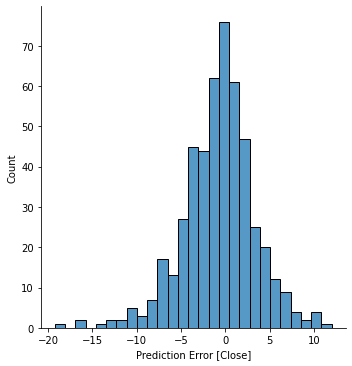

In [42]:
plt.figure(figsize=(10, 8))
plotErrorHist(inversed_dfs['Model-1'])

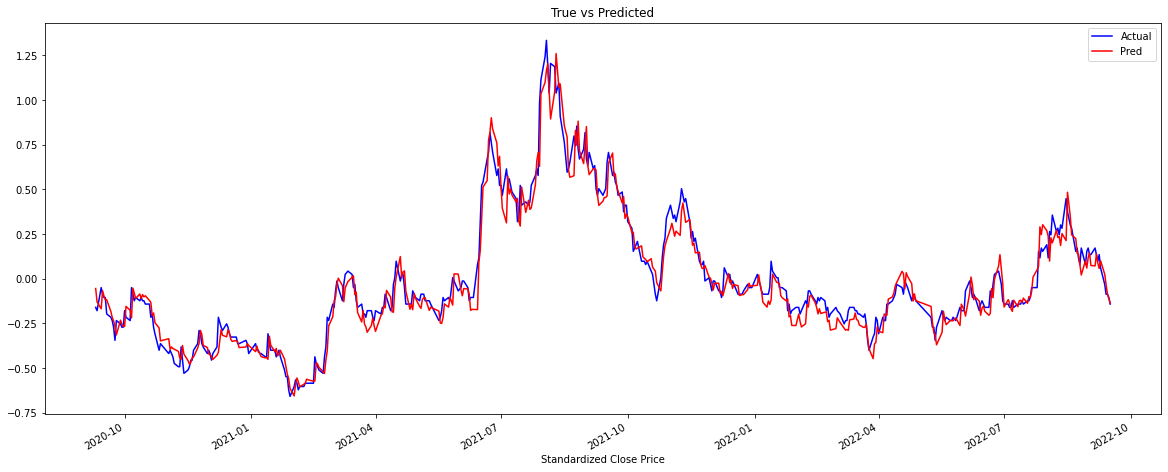

In [43]:
plot_pred_act(predictions_dfs['Model-1'])

## Save the best model

In [44]:
import keras

In [45]:
models['Model-1'][0].save('./models/fren.h5')

In [46]:
loadedModel = keras.models.load_model('./models/fren.h5')

In [47]:
loadedModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             13800     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________


In [48]:
yhat = loadedModel.predict(X_test)

16/16 [==============================] - 1s 2ms/step
